In [ ]:
#default_exp audio.core
#default_cls_lvl 3

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.notebook.showdoc import show_doc
import torchaudio
import torchaudio.transforms as torchaud_tfm

from IPython.display import display, Audio
from dataclasses import dataclass, asdict, is_dataclass, make_dataclass
from torchaudio.transforms import Spectrogram, AmplitudeToDB, MFCC
import librosa.display

In [ ]:
torchaudio.__version__

'0.3.0+faed00e'

In [ ]:
#TensorBase??

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Create __all__ for audio</div>

In [ ]:
#export
_all_ = ['AudioGetter', 'get_audio_files', 'AudioItem', 'OpenAudio', 'AudioSpectrogram', 'AudioToSpec',
        'SpectrogramConfig', 'AudioConfig', 'audio_extensions']

## Basic types

This section regroups the basic types used in vision with the transform that create objects of those types.

In [ ]:
#export
audio_extensions = tuple(str.lower(k) for k, v in mimetypes.types_map.items() if v.startswith('audio/'))

In [ ]:
#export
def get_audio_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=audio_extensions, recurse=recurse, folders=folders)

In [ ]:
#export
def AudioGetter(suf='', recurse=True, folders=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`, only in `folders`, if specified."
    def _inner(o, recurse=recurse, folders=folders): 
        return get_audio_files(o/suf, recurse, folders)
    return _inner

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Get data_url stuff working</div>

In [ ]:
# data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
# data_folder = download_url(data_url, get_path(data_url))

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')

In [ ]:
p.ls()

(#3844) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
audio_get_func = AudioGetter("", recurse=True, folders=None)

In [ ]:
audio_get_func

<function __main__.AudioGetter.<locals>._inner(o, recurse=True, folders=None)>

In [ ]:
files = audio_get_func(p)

In [ ]:
files[0]

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br> 
    1. Return to lazy loading. <br>
    2. Refactor out @property pattern using the fastai v2 way <br>
    3. Get rid of path as part of the tuple? <br>
</div>

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Factor</div

In [ ]:
#export
class AudioItem(tuple):
    def show(self, ctx=None, **kwargs): 
        print(f"File: {self.path}")
        display(Audio(self.sig, rate=self.sr))
    
    @classmethod
    def create(cls, fn, **kwargs):
        sig, sr = torchaudio.load(fn)
        return cls((sig, sr, fn), **kwargs)
    
    @property
    def sig(self) : return self[0]
    @property
    def sr(self)  : return self[1]
    @property
    def path(self): return self[2]
    @property
    def duration(self): return self.nsamples/float(self.sr)
    @property
    def nsamples(self): return self.sig.shape[-1]
    @property
    def nchannels(self): return self.sig.shape[0]

In [ ]:
type(AudioItem((None, None, files[0])))

__main__.AudioItem

In [ ]:
test_item = AudioItem.create(files[0]); test_item

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
          -6.1035e-05, -1.8311e-04]]),
 16000,
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav'))

In [ ]:
test_item[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
         -6.1035e-05, -1.8311e-04]])

In [ ]:
test_item.sr, test_item.duration, test_item.nchannels, test_item.nsamples

(16000, 3.28, 1, 52480)

In [ ]:
test_item.show()

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


In [ ]:
#export
class OpenAudio(Transform):
    def __init__(self, items):
        self.items = items

    def encodes(self, i):
        o = self.items[i]
        return AudioItem.create(o)
    
    def decodes(self, i)->Path: 
        return self.items[i]

repr of Transform is:  
classname: self.use_as_item {self.encodes} {self.decodes}  
encodes and decodes are TypeDispatches whose reprs are str of dict where k/v pair is typename and function that handles that type

In [ ]:
oa = OpenAudio(files); oa

OpenAudio: True {'object': 'encodes'} {'object': 'decodes'}

In [ ]:
type(oa)

__main__.OpenAudio

In [ ]:
#??Transform
#??TypeDispatch

In [ ]:
oa.encodes(1)

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.0518e-05,
          -1.2207e-04,  1.8311e-04]]),
 16000,
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav'))

In [ ]:
oa.decodes(1)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav')

In [ ]:
oa.items[0]

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')

## Create functions to wrap TorchAudio 

In [ ]:
#export
_GenSpec    = torchaudio.transforms.Spectrogram
_GenMelSpec = torchaudio.transforms.MelSpectrogram
_GenMFCC    = torchaudio.transforms.MFCC
_ToDB        = torchaudio.transforms.AmplitudeToDB

## Audio Spectrogram

In [ ]:
# TensorImageBase??
# TensorImage??
# TensorBase??
# Tensor??
# BypassNewMeta??

<div class='alert alert-block alert-warning'><strong>CAUTION:</strong> Extending TensorImageBase may not be 
    what we want to do as it's show method appears to be displaying a compressed x-axis to make the images fit in the case
    that they are wider than 200px </div>

In [ ]:
#export
class AudioSpectrogram(TensorImageBase):
    @classmethod
    def create(cls, sg, settings=None, path=None, start=None, end=None):
        x = cls(sg)
        store_attr(x, 'settings,path,start,end')
        return x
    
    '''def show(self):
        sg = self[0]
        print(sg.shape)
        print(type(sg))
        librosa.display.specshow(sg.numpy())
    '''

<div class='alert alert-block alert-info'><strong>TO-DO:</strong> Add in the thing that catches bad kwargs</div

In [ ]:
#export
@delegates(_GenSpec.__init__)
@delegates(_GenMelSpec.__init__, keep=True)
@delegates(_ToDB.__init__, keep=True)
class AudioToSpec(Transform):
    def __init__(self, mel=True, to_db=True, **kwargs):
        transforms = L()
        if mel:   transforms += self.add_func(_GenMelSpec, kwargs)
        else:     transforms += self.add_func(_GenSpec, kwargs)
        if to_db: transforms += self.add_func(_ToDB, kwargs)
            
        self.transformer = nn.Sequential(*transforms)
        store_attr(self, 'to_db,mel')
        self.tfm_kwargs = kwargs
        
    @classmethod
    def from_cfg(cls, audio_cfg):
        cfg = asdict(audio_cfg) if is_dataclass(audio_cfg) else audio_cfg
        return cls(**cfg)
    
    def encodes(self, x:AudioItem):
        return AudioSpectrogram(self.transformer(x.sig).detach())
    
    @staticmethod
    def add_func(func, kwargs):
        func_args = {k:v for k,v in kwargs.items() 
                     if k in inspect.signature(func).parameters.keys()}
        return func(**func_args)

In [ ]:
voice_mel_cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
AudioToSpec(**voice_mel_cfg)
AudioToSpec()

AudioToSpec: True {'AudioItem': 'encodes'} {}

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00340.wav


<class '__main__.AudioSpectrogram'>
torch.Size([128, 443])
<class '__main__.AudioSpectrogram'>


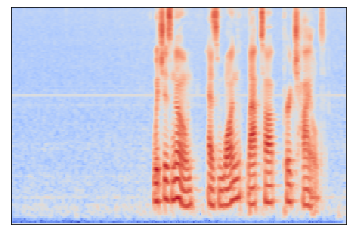

In [ ]:
oa = OpenAudio(files)
item100 = oa.encodes(100)
item100.show()
a2s = AudioToSpec(**voice_mel_cfg)
sg = a2s(item100)
print(type(sg))
sg.show()

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br>
    1. Remove SpectrogramConfig/settings and just dump all settings in the function?</div><br>

In [ ]:
#export
@delegates(_GenMFCC.__init__)
def AudioToMFCC(**kwargs):
    def _inner(ai:AudioItem)->AudioSpectrogram:
        mfcc = _GenMFCC(sample_rate=ai.sr, **kwargs)(ai.sig)
        return AudioSpectrogram.create(mfcc.detach())        
    return _inner

In [ ]:
AudioToMFCC()

<function __main__.AudioToMFCC.<locals>._inner(ai: __main__.AudioItem) -> __main__.AudioSpectrogram>

### MelSpecPipe

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00340.wav


torch.Size([128, 443])
<class '__main__.AudioSpectrogram'>


TypeError: show() got an unexpected keyword argument 'ctx'

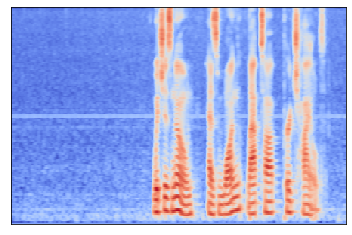

In [ ]:
mel_cfg = {'n_fft':2560,'hop_length':256}
oa = OpenAudio(files)
item100 = oa.encodes(100)
item100.show()
a2s = AudioToSpec(**mel_cfg)
a2s(item100).show()
db_mel_pipe = Pipeline([oa,AudioToSpec(**mel_cfg)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### Raw Spec Pipe

In [ ]:
cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec(mel=False, to_db=False,)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### DBScale non-mel Pipe

In [ ]:
cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec(mel=False)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### from config pipe 

In [ ]:
cfg = {'mel':False, 'n_fft':2560, 'f_max':22050., 'hop_length':64}
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(cfg)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### MFCC Pipe

In [ ]:
db_mel_pipe = Pipeline([oa, AudioToMFCC(n_mfcc=20), ], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

## Configs

In [ ]:
f = inspect.signature(torchaud_tfm.Spectrogram).parameters

In [ ]:
f["n_fft"].default

In [ ]:
#export
def config_from_func(func, name):
    args = inspect.signature(func).parameters
    namespace = {k:v.default for k, v in args.items()}
    return make_dataclass(name, args, namespace=namespace)

SpectrogramConfig    = config_from_func(_GenSpec, "SpectrogramConfig")
MelSpectrogramConfig = config_from_func(_GenMelSpec, "MelSpectrogramConfig")
MFCCConfig           = config_from_func(_GenMFCC, "MFCCConfig")

In [ ]:
sg_cfg = SpectrogramConfig(n_fft=2000); sg_cfg

In [ ]:
MelSpectrogramConfig(hop_length=128)

In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(sg_cfg)], as_item=True)
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

In [ ]:
MFCCConfig()

## Export

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)